# Projet NLP
**Objectif :** Créer un modèle capable de lire une critique de film et de prédire si elle est **Positive** ou **Négative**.

**Les étapes :**
1. Chargement des données
2. Nettoyage du texte
3. Transformation du texte en nombres (Vectorisation)
4. Entraînement du modèle (Machine Learning)
5. Test avec nos propres phrases

In [3]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## 1. Création du Dataset
Pour ce tutoriel, nous allons créer un petit jeu de données manuellement pour comprendre le principe.
Nous avons deux colonnes :
* `text`: La critique du film.
* `sentiment`: 1 pour Positif, 0 pour Négatif.

In [4]:

# Listes de mots pour la génération aléatoire
sujets = ["Ce film", "Le scénario", "Le jeu d'acteur", "La réalisation", "La bande son", "L'histoire", "Ce réalisateur"]
verbes_pos = ["est", "était", "reste", "demeure"]
verbes_neg = ["est", "était", "semble", "est devenu"]

adjectifs_pos = ["incroyable", "génial", "superbe", "fantastique", "émouvant", "captivant", "magique", "brillant", "spectaculaire", "original"]
adjectifs_neg = ["nul", "ennuyeux", "horrible", "mauvais", "prévisible", "raté", "lent", "décevant", "catastrophique", "vide"]

complements_pos = ["à voir absolument", "un chef-d'oeuvre", "une pure merveille", "je recommande", "quel talent", "un très bon moment", "une réussite"]
complements_neg = ["une perte de temps", "à éviter", "quel désastre", "je me suis endormi", "sans intérêt", "une honte", "argent gâché"]

# Listes pour stocker nos 1000 phrases
textes = []
sentiments = []

# Génération de 500 avis POSITIFS (Sentiment = 1)
for _ in range(500):
    phrase = f"{random.choice(sujets)} {random.choice(verbes_pos)} {random.choice(adjectifs_pos)}, {random.choice(complements_pos)}."
    textes.append(phrase)
    sentiments.append(1)

# Génération de 500 avis NÉGATIFS (Sentiment = 0)
for _ in range(500):
    phrase = f"{random.choice(sujets)} {random.choice(verbes_neg)} {random.choice(adjectifs_neg)}, {random.choice(complements_neg)}."
    textes.append(phrase)
    sentiments.append(0)

# Création du DataFrame
data_gen = {'text': textes, 'sentiment': sentiments}
df = pd.DataFrame(data_gen)

# Mélanger les données pour ne pas avoir tous les positifs au début
df = df.sample(frac=1).reset_index(drop=True)

# Vérification
print(f"Dimensions : {df.shape} ")
display(df.head(10))

Dimensions : (1000, 2) 


,text,sentiment
0,"Ce réalisateur est devenu prévisible, sans int...",0
1,"Ce réalisateur était horrible, argent gâché.",0
2,"La réalisation était incroyable, une pure merv...",1
3,"La bande son est devenu ennuyeux, une honte.",0
4,"Ce film reste incroyable, un chef-d'oeuvre.",1
5,"La bande son est devenu prévisible, argent gâché.",0
6,"Ce réalisateur semble décevant, quel désastre.",0
7,"La bande son reste original, une réussite.",1
8,"Ce réalisateur est spectaculaire, une pure mer...",1
9,"Ce film reste superbe, une réussite.",1


## 2. La Vectorisation (Bag of Words)
Nous allons utiliser `CountVectorizer`.
Il va créer un tableau géant où :
* Chaque ligne est une critique.
* Chaque colonne est un mot unique du vocabulaire.
* La valeur est le nombre de fois où le mot apparaît.

In [6]:
# Initialisation du vectoriseur
vectorizer = CountVectorizer()

# On "apprend" le vocabulaire et on transforme le texte en matrice de nombres
X = vectorizer.fit_transform(df['text'])

# Les étiquettes (réponses)
y = df['sentiment']

# Pour comprendre, regardons le vocabulaire appris
print("Vocabulaire appris :", vectorizer.get_feature_names_out())
print("\nForme de la matrice X (Lignes, Mots) :", X.shape)

Vocabulaire appris : ['absolument' 'acteur' 'argent' 'bande' 'bon' 'brillant' 'captivant'
 'catastrophique' 'ce' 'chef' 'de' 'demeure' 'devenu' 'décevant'
 'désastre' 'endormi' 'ennuyeux' 'est' 'fantastique' 'film' 'gâché'
 'génial' 'histoire' 'honte' 'horrible' 'incroyable' 'intérêt' 'je' 'jeu'
 'la' 'le' 'lent' 'magique' 'mauvais' 'me' 'merveille' 'moment' 'nul'
 'oeuvre' 'original' 'perte' 'prévisible' 'pure' 'quel' 'raté'
 'recommande' 'reste' 'réalisateur' 'réalisation' 'réussite' 'sans'
 'scénario' 'semble' 'son' 'spectaculaire' 'suis' 'superbe' 'talent'
 'temps' 'très' 'un' 'une' 'vide' 'voir' 'émouvant' 'était' 'éviter']

Forme de la matrice X (Lignes, Mots) : (1000, 67)


## 3. Séparation des données (Train / Test)
Même si notre dataset n'est pas très grand, on fait un :
* **Train set :** Pour entraîner le modèle.
* **Test set :** Pour vérifier s'il fonctionne sur des phrases qu'il n'a jamais vues.

In [7]:
# On divise : 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Données d'entraînement : {X_train.shape[0]} phrases")
print(f"Données de test : {X_test.shape[0]} phrases")

Données d'entraînement : 800 phrases
Données de test : 200 phrases


## 4. Entraînement du Modèle
Nous allons utiliser l'algorithme **Naive Bayes (MultinomialNB)**.
C'est un algorithme classique pour le texte car il est très rapide et efficace pour calculer des probabilités basées sur la fréquence des mots.

In [8]:
# Création du modèle
model = MultinomialNB()

# Entraînement sur les données d'entraînement
model.fit(X_train, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


## 5. Évaluation et Test Réel
Voyons si le modèle arrive à bien prédire les données de test, puis essayons avec **des phrases de test**.

In [9]:
# Prédiction sur le set de test
y_pred = model.predict(X_test)

# Affichage de la précision
print(f"Précision du modèle : {accuracy_score(y_test, y_pred) * 100}%")

nouvelles_phrases = [
    "C'est un bon film, j'ai aimé",
    "Je déteste ce réalisateur, c'est nul"
]

# Attention : on doit transformer ces phrases en nombres avec le MÊME vectoriseur qu'au début
nouveaux_vecteurs = vectorizer.transform(nouvelles_phrases)

# Prédiction
predictions = model.predict(nouveaux_vecteurs)

for phrase, pred in zip(nouvelles_phrases, predictions):
    sentiment = "POSITIF" if pred == 1 else "NÉGATIF"
    print(f"'{phrase}' -> Sentiment détecté : {sentiment}")

Précision du modèle : 100.0%
'C'est un bon film, j'ai aimé' -> Sentiment détecté : POSITIF
'Je déteste ce réalisateur, c'est nul' -> Sentiment détecté : NÉGATIF


# 6. Visualisation des données
 Avant de faire confiance à un modèle, il est crucial de visualiser les données sur lesquelles il travaille.

## 6.1 Répartition des sentiments

/var/folders/sc/xwskzztn6vz8ngpx8vk27dsh0000gn/T/ipykernel_4658/2755921435.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette=['#FF6B6B', '#4ECDC4'])
/var/folders/sc/xwskzztn6vz8ngpx8vk27dsh0000gn/T/ipykernel_4658/2755921435.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Négatif (0)', 'Positif (1)'])


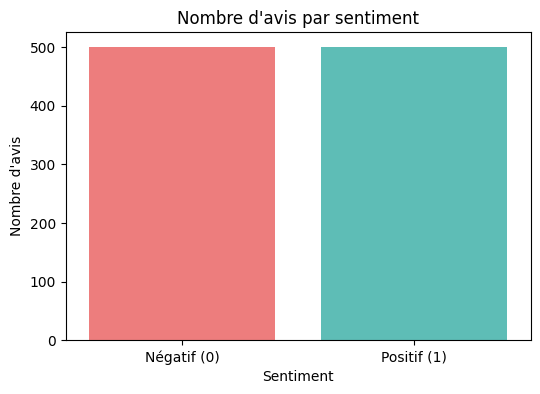

In [10]:
plt.figure(figsize=(6, 4))

# Création du graphique en barres
ax = sns.countplot(x='sentiment', data=df, palette=['#FF6B6B', '#4ECDC4'])

# Amélioration des étiquettes
ax.set_xticklabels(['Négatif (0)', 'Positif (1)'])
plt.title('Nombre d\'avis par sentiment')
plt.ylabel('Nombre d\'avis')
plt.xlabel('Sentiment')

plt.show()

## 6.2 Nuages de Mots
Le nuage de mots permet de voir en un coup d'œil les termes les plus fréquents. Plus un mot est écrit gros, plus il apparaît souvent.

Nous allons générer **deux** nuages :
1.  Un pour les avis **Positifs**.
2.  Un pour les avis **Négatifs**.

Cela nous permettra de voir si des mots distincts ressortent pour chaque catégorie.

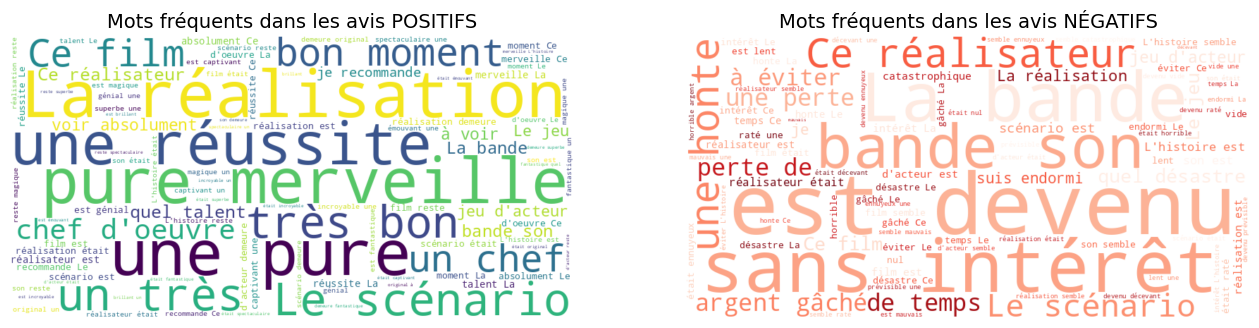

In [13]:
texte_positif = " ".join(review for review in df[df['sentiment'] == 1]['text'])
texte_negatif = " ".join(review for review in df[df['sentiment'] == 0]['text'])
wc_pos = WordCloud(background_color='white', width=800, height=400).generate(texte_positif)
wc_neg = WordCloud(background_color='white', width=800, height=400, colormap='Reds').generate(texte_negatif)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title('Mots fréquents dans les avis POSITIFS', fontsize=14)
axes[0].axis('off') # On cache les axes chiffrés
axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title('Mots fréquents dans les avis NÉGATIFS', fontsize=14)
axes[1].axis('off')
plt.show()

Ces nuages de mots permettent une comparaison immédiate du vocabulaire dominant entre les deux classes. 

Cependant, cette représentation comporte des biais à prendre en compte :

Les mots "passe-partout" : Des termes contextuels comme film, bande son ou scénario sont omniprésents dans les deux catégories, ce qui peut masquer des adjectifs de sentiment plus discriminants mais moins fréquents.

La perte de contexte : En isolant les mots , on perd la structure des phrases, notamment les négations (ex: "pas terrible" est séparé), ce qui peut fausser l'interprétation rapide.